In [2]:
!pip install datasets transformers scikit-learn nltk lime --quiet

# Import libraries

In [3]:
import pandas as pd
import numpy as np
import torch
import nltk
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from lime.lime_text import LimeTextExplainer
from torch.nn.functional import softmax
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load dataset from Hugging Face

In [4]:
dataset = load_dataset("Hasib18/fake-news-dataset")
df = dataset['train'].to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/415 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57707 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14427 [00:00<?, ? examples/s]

# Clean the text

In [5]:
df['clean_text'] = df['text'].str.lower()

# Split data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# Tokenizer

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Encode the data

In [8]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

# Prepare torch Dataset

In [9]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train.tolist())
test_dataset = NewsDataset(test_encodings, y_test.tolist())


# Load pre-trained model

In [10]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training arguments

In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    learning_rate=1e-5,
    logging_dir='./logs',
)

# Trainer

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model

In [22]:
trainer.train()

Step,Training Loss
500,0.018400
1000,0.020800


TrainOutput(global_step=1443, training_loss=0.01898401971501108, metrics={'train_runtime': 2658.0051, 'train_samples_per_second': 17.368, 'train_steps_per_second': 0.543, 'total_flos': 6115357458954240.0, 'train_loss': 0.01898401971501108, 'epoch': 1.0})

# Evaluate on test set

In [23]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print("Classification Report:\n", classification_report(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5535
           1       0.99      0.99      0.99      6007

    accuracy                           0.99     11542
   macro avg       0.99      0.99      0.99     11542
weighted avg       0.99      0.99      0.99     11542

Accuracy: 0.9932420724311212


# Visualization

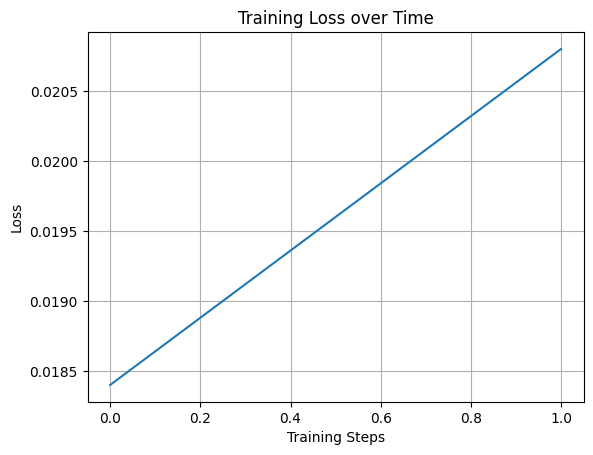

In [24]:
import matplotlib.pyplot as plt

training_loss = trainer.state.log_history

losses = [entry['loss'] for entry in training_loss if 'loss' in entry]
steps = list(range(len(losses)))

plt.plot(steps, losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.grid(True)
plt.show()


# Save Model

In [28]:
trainer.save_model("distilbert-fake-news-detector")
tokenizer.save_pretrained("distilbert-fake-news-detector_tokenizer")

('distilbert-fake-news-detector_tokenizer/tokenizer_config.json',
 'distilbert-fake-news-detector_tokenizer/special_tokens_map.json',
 'distilbert-fake-news-detector_tokenizer/vocab.txt',
 'distilbert-fake-news-detector_tokenizer/added_tokens.json',
 'distilbert-fake-news-detector_tokenizer/tokenizer.json')